In [1]:
import numpy as np
import pandas as pd
import random
import math
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [2]:
citysNum = 30
data = np.array(pd.read_excel("../dataSet/cities.xlsx",header=None))
#data = np.random.random((citysNum,2))

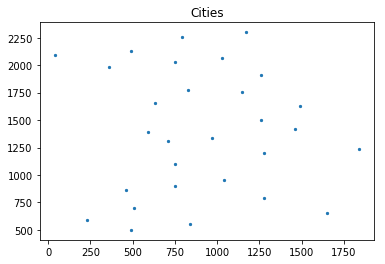

In [3]:
plt.title("Cities")
plt.scatter(data[:,0],data[:,1],s=5)
plt.show()

In [4]:
dist = squareform(pdist(data, metric='euclidean'))  # 计算N个城市的距离矩阵

In [5]:
class GA_TSP():
    def __init__(self, data, N, matingRate, variationRate ,max_epoch): # 初始化种群
        self.N    = N    #种群数量
        self.dist = squareform(pdist(data, metric='euclidean'))  # 计算N个城市的距离矩阵
        self.cityNums      = data.shape[0]          # 城市数目
        self.matingRate    = matingRate             # 交配概率
        self.variationRate = variationRate          # 变异概率
        self.max_epoch     = max_epoch              # 最大迭代次数
        self.fitValues     = np.zeros((1,N))        # 适应值
        self.bestGroup     = -np.ones((1,self.cityNums)) # 最优解
        self.bestFitValue  = float("inf")           # 最优值
        self.bestIndex     = [-float("inf"),-float("inf")]  # 当前最优解的索引
        # N次随机不放回抽样
        groups = list()
        for i in range(N): # 随机生成N个种群           
            temp = random.sample(range(self.cityNums), self.cityNums)
            groups.append(temp)
        self.groups = np.array(groups) # 种群
        self.calcuFitValues()
        self.bestGroup, self.bestFitValue = self.calcuBest()
    
    def calcuFitValues(self):  # 计算适应性
        for i in range(self.N):
            fitValue = 0
            for c in range(self.cityNums-1):
                fitValue += self.dist[self.groups[i,c], self.groups[i,c+1]]
            self.fitValues[0][i] = 1 / fitValue
        return 
    
    def calcuBest(self):  # 获取当前最优值和最优解
        bestGroup = self.groups[np.argmax(self.fitValues[0])]
        bestFitValue = 1 / np.max(self.fitValues[0]) 
        return bestGroup, bestFitValue
    
    def select(self): # 轮盘赌
        groups = list()
        p = self.fitValues[0] / sum(self.fitValues[0])  # 适应值比例
        for t in range(self.N):
            m = 0
            r = random.random()
            for i in range(self.N):
                m += p[i]
                if r < m:
                    groups.append(self.groups[i])
                    break
        return np.array(groups)
    
    def select2(self): # 最优化保存策略
        bestGroup = self.groups[np.argmax(self.fitValues[0])]
        self.groups[np.argmin(self.fitValues[0])] = bestGroup.copy()
        self.bestIndex[0] = np.argmax(self.fitValues[0])
        self.bestIndex[1] = np.argmin(self.fitValues[0])
        return self.groups
    
    def mating(self):   # 有序交叉法
        willmate = list()
        for k, group in enumerate(self.groups):
            if k in self.bestIndex:
                continue # 当前最优解不参与交配
            r = random.random()
            if r < self.matingRate:
                willmate.append(group)
        if len(willmate) >= 2 : # 交配个体大于2才进行本轮交配
            if len(willmate) % 2 != 0:  # 交配个体为基数
                delIndex = random.randint(0,len(willmate)-1)  #随机剔除一个
                del willmate[delIndex]
            matingMap = random.sample(range(len(willmate)), len(willmate))
            for i in range(0, len(matingMap), 2):  # 有序交叉 交配过程
                x1 = matingMap[i]
                x2 = matingMap[i+1]
                positions = random.sample(range(self.cityNums), 2)  # 随机两个交叉位
                positions.sort()
                com1  = list(willmate[x1][positions[0]:positions[1]+1])
                com2  = list(willmate[x2][positions[0]:positions[1]+1])
                limit = list(range(positions[0])) + list(range(positions[1]+1, self.cityNums))
                for p in limit:            
                    temp = willmate[x1][p]
                    if willmate[x2][p] not in com1:
                        willmate[x1][p] = willmate[x2][p]
                    else:
                        index = com1.index(willmate[x2][p])
                        while com2[index] in com1:
                            index = com1.index(com2[index])
                        willmate[x1][p] = com2[index]
                    if temp not in com2:
                        willmate[x2][p] = temp
                    else:
                        index = com2.index(temp)
                        while com1[index] in com2:
                            index = com2.index(com1[index])
                        willmate[x2][p] = com1[index]
        return
    
    def variation(self):  # 倒置变异
        for k, group in enumerate(self.groups):
            if k in self.bestIndex:
                continue # 当前最优解不变异
            r = random.random()
            if r < self.variationRate:
                positions = random.sample(range(self.cityNums), 2) # 随机两个变异
                positions.sort()
                diff = (positions[1] - positions[0])/2
                for i in range(positions[0], math.ceil(diff+positions[0])):  # 倒置操作
                    temp = group[i]
                    group[i] = group[int(i+(positions[0]+diff-i)*2)]
                    group[int(i+(positions[0]+diff-i)*2)] = temp
        return 
    
    def process(self):  # 进化过程
        t = 0  # 当前迭代次数
        while(t < self.max_epoch):
            t += 1
            self.groups = self.select2()  #选择
            self.mating() #交配
            self.variation() #变异
            self.calcuFitValues() #计算适应值
            bestGroup, bestFitValue = self.calcuBest() #获取最优值和最优解
            '''
            if abs(bestFitValue - self.bestFitValue) < 1e-10:
                self.bestGroup    = bestGroup
                self.bestFitValue = bestFitValue
                break
            else:
                self.bestGroup    = bestGroup
                self.bestFitValue = bestFitValue
            '''
            self.bestGroup    = bestGroup
            self.bestFitValue = bestFitValue
            #print('最优解:', self.bestGroup)
            #print('最优值:', self.bestFitValue)
        print('总计迭代', t, '次')
        print('最优解:', self.bestGroup)
        print('最优值:', self.bestFitValue)
        return self.bestGroup, self.bestFitValue

In [8]:
N = 1000  #种群规模
matingRate    = 0.9   #交配概率
variationRate = 0.01  #变异概率
max_epoch     = 10000 #最大迭代次数
ga = GA_TSP(data, N, matingRate, variationRate, max_epoch)
bestGroup, bestFitValue = ga.process()

总计迭代 10000 次
最优解: [ 0 27 11  5 20 25  8  4  2 28  1 19 14 17 13 21 16 10  3  9 12 23  7 26
 22  6 24 18 15]
最优值: 9988.752764459849


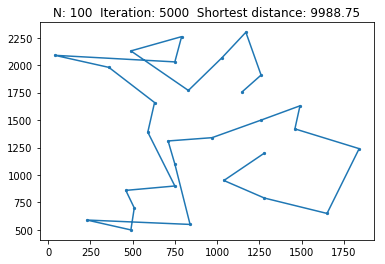

In [10]:
bestFitValue = round(bestFitValue,2)
plt.title("N: "+str(N)+"  Iteration: "+str(max_epoch)+"  Shortest distance: "+ str(bestFitValue))
plt.scatter(data[:,0],data[:,1],s=5)
plt.plot(data[bestGroup,0],data[bestGroup,1])
fileName = "%s%s%s" %("最短路径",str(bestFitValue),".png")
plt.savefig(fileName)
plt.show()